## Introduction tutorial

The fundamental object of analysis in this package is an NCData object. Each object is initialized with a single netcdf file or an ensemble of files, and will keep track of any manipulations carried.
Behind the scenes most of the manipulations are done using CDO or NCO. Objects will keep track of all CDO/NCO commands used. However, unless you are experienced with CDO or NCO you can ignore all of this.

# Opening netcdf data 
I will illustrate the basic usage using a climatology of global sea surface temperature from NOAA.
We can download this using wget as follow.

In [1]:
from IPython.display import clear_output
! wget ftp://ftp.cdc.noaa.gov/Datasets/COBE2/sst.mon.ltm.1981-2010.nc
clear_output()

The first step in any analysis will be to import nchack, which I will call nc as shorthand. Please note I am suppressing warnings to make this notebook more readable. I do not recommend suppressing warnings....

In [2]:
import nchack as nc
import warnings
warnings.filterwarnings('ignore')

Tip: include atexit.register(nchack.clean_all) after loading nchack


Under the hood nchack will generate temporary netcdf files. The package is designed to remove temp files that are no longer in use, and will automatically clean up any temporary files generated when Python closes. However, this is not 100% guaranteed to work during system crashes etc.

It is therefore recommended to do a deep_clean at the start of any session to remove any leftover netcdf files that might have existed in a previous sessions. Obviously, do not run this if you have multiple instances of nchack running simultaneously.

In [3]:
nc.deep_clean()

# Creating a tracker

We can then set up the tracker file which we will use for manipulating the SST climatology.

In [4]:
ff =  "sst.mon.ltm.1981-2010.nc"
tracker = nc.NCTracker(ff)

# Accessing tracker attributes

At this point there is very little useful information in the tracker. Essentially, all it tell us is the start file. This will always remain the same.

In [5]:
tracker.start

'sst.mon.ltm.1981-2010.nc'

The current state of the tracker can be found as follows.

In [6]:
tracker.current

'sst.mon.ltm.1981-2010.nc'

We tracker history as follows, which is initially empty.

In [7]:
tracker.history

[]

A simple, but important first task when analyzing netcdf data is knowing the variables in the file. We can do this quickly by accessing the variables attribute

In [8]:
tracker.variables

['sst', 'valid_yr_count']

Often, we will want to know the size of a tracker. This is most relevant when we are working with multiple files. We can do this by accessing the size attribute. To speed up computations, variables and size are computed lazily.

In [9]:
tracker.size

Number of files: 1
File size: 4.670688 MB


In this case we can see that the file is 4 MB, and we are also told that there is only one file.

# Variable selection and geographic clipping 
We can clip netcdf files in space or time using clip. Let's say we only cared about temperature in July for the North Atlantic. This be found very easily using the following.

netcdf files often have variables that we are not interested in. We can therefore easily select or delete variables.
If we want to select variables we can use the select_variables method, which requires either a single variable or a list of variables. Here I will select sst.

In [10]:
tracker.select_variables("sst")

We can now see that there is only one variable in the tracker

In [11]:
tracker.variables

['sst']

We can also that a temporary file has been created with only this variable in it

In [12]:
tracker.current

'/tmp/nchacknmbkniqznchacknchacknmbkniqznchacktmpca3rp_q4.nc'

If we want to clip the file geographically we can use the clip method. All we need is the longitude and latitude range. So if we wanted to clip the SST data to the North Atlantic we would do the following.

In [13]:
tracker.clip(lon = [-80, 20], lat = [30, 80])

We have now carried out some manipulations on the tracker. So, the current file has now changed.

Likewise, we now have a history to look at.

In [14]:
tracker.history

['cdo -s -selname,sst sst.mon.ltm.1981-2010.nc /tmp/nchacknmbkniqznchacknchacknmbkniqznchacktmpca3rp_q4.nc',
 'cdo -s -sellonlatbox,-80,20,30,80 /tmp/nchacknmbkniqznchacknchacknmbkniqznchacktmpca3rp_q4.nc /tmp/nchacknmbkniqznchacknchacknmbkniqznchacktmp0ovs1npj.nc']

This will give us the list of CDO or NCO commands used under the hood. nchack is designed to be usable without any prior knowledge of CDO or NCO. 

# Importing a tracker in xarray

xarray is a powerful netcdf manipulation tool. In fact, in some use cases it will be more computationally efficient than CDO or NCO. nchack has a built in method for reading the tracker's current state in as an xarrary format, to_xarray.

In [15]:
tracker.to_xarray().sst.plot(col = "time", col_wrap = 3)

# Deleting an object

If we want to delete a tracker we simply use the standard python del approach. nchack has been designed so that it is constantly cleaning up the system using a simple rule: only keep temp files created if they are among the current files of trackers.
Right now, we only have one tracker, called "tracker". So if we delete tracker it will also delete the current temp file from that tracker. We can see this by looking at what happens to the current state of the tracker when we delete. Right now it exists on the system. 


In [16]:
import os
x = tracker.current
os.path.exists(x)

True

But if we delete the tracker, it will disappear.

In [17]:
del tracker
os.path.exists(x)

False

# Viewing a tracker using ncview

One of the most popular ways to view a netcdf file is the command line tool ncview. nhack therefore has a simple wrapper around this.

In [18]:
ff =  "sst.mon.ltm.1981-2010.nc"
tracker = nc.NCTracker(ff)
tracker.view()

# Statistical operations

nchack has a large number of built in statistical operations, largely built around the methods available in CDO.

# Time averaging
Averaging in time is one of the most common operations required on netcdf data. nchack allows users to calculate long-term time averages, monthly climatologies, seasonal summaries and many other common statistics.

In this case we are analyzing a monthly climatology of SST. However, what we really might be interested in is the annual average. This can be calculated using the simple mean method, which will calculate the mean over all time steps.

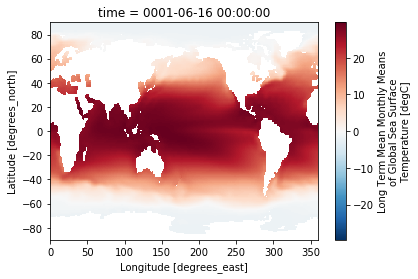

In [19]:

ff =  "sst.mon.ltm.1981-2010.nc"
tracker = nc.NCTracker(ff)
tracker.select_variables("sst")
tracker.mean()
tracker.to_xarray().sst.plot()

Instead of the annual mean, we might be interested in the range of temperatures during the year.

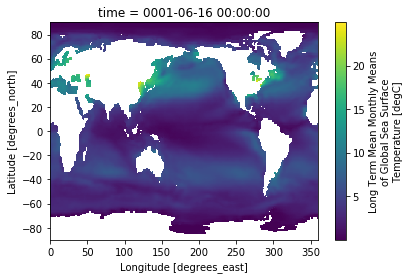

In [20]:
ff =  "sst.mon.ltm.1981-2010.nc"
tracker = nc.NCTracker(ff)
tracker.select_variables("sst")
tracker.range()
tracker.to_xarray().sst.plot()

Other operations, such as maximum, minimum, and standard deviation are available.

# Spatial statistics

Let's move on to some more advanced methods. I will illustrate these using NOAA's long-term monthly global data set of sea surface temperatures from 1850 to the present day.
You can learn more about this data set here: https://www.esrl.noaa.gov/psd/data/gridded/data.cobe2.html.
To download it you can use wget. This file is approximately 500 MB.

In [21]:
! wget ftp://ftp.cdc.noaa.gov/Datasets/COBE2/sst.mon.mean.nc
clear_output()

This is a long-term data set of global sea surface temperature. So, let's find out what has happened to average global sea surface temperature since 1850. Unsurprising spoiler: it has been going up.
Let's start by setting up the tracker.

In [22]:
ff =  "sst.mon.mean.nc"
tracker = nc.NCTracker(ff)

We now need to calculate the average global SST. We can do this using the spatial_mean method. This will calculate an area weighted mean for each time step.

In [23]:
tracker.spatial_mean()

We can now plot the time series of monthly global mean SST since 1850

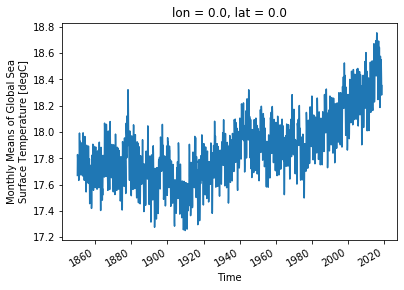

In [24]:
tracker.to_xarray().sst.plot()

Our time series shows that, as expected SST increased during the 20th Century. However, this figure has too much noise. We do not care about month to month variations.Instead, let's look at the rolling 20 year mean.
To do this, we will need to first calculate an annual mean then calculated the rolling mean using a window of 20 years. Alternatively, we can just calculate a rolling mean on the initial data using a rolling mean of 20*12 = 240 months.

In [25]:
ff =  "sst.mon.mean.nc"
tracker = nc.NCTracker(ff)
tracker.spatial_mean()

To calculate the annual mean we can simply use the yearly_mean method.

In [26]:
tracker.yearly_mean()

To calculate the rolling mean, we can use rolling_mean, with window set to 20.

In [27]:
tracker.rolling_mean(window = 20)

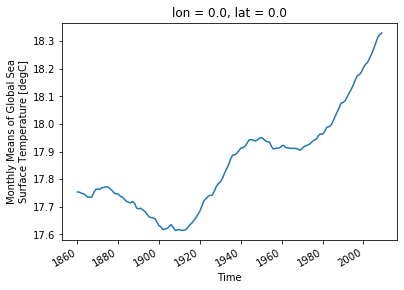

In [28]:
tracker.to_xarray().sst.plot()

This looks much cleaner. Please note that at present nchack does not adjust the time outputs from CDO. So in this case the rolling mean is centred in the middle of the 20 year period. As nchack evolves more windowing options will be provided to users.